In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import warnings
import numpy as np

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

In [34]:

def plot_hourly_data(df, value_col, title='Power Consumption'):
    """
    Takes a DataFrame, cleans the time column, calculates a rolling average,
    and returns an interactive Plotly figure.
    
    Parameters:
    - df: The pandas DataFrame containing the data.
    - time_col: The name of the column with 'Hour Ending' strings.
    - value_col: The name of the column with the load/power values.
    - title: Title for the chart.
    """
    # Create a copy to avoid modifying the original dataframe
    plot_df = df.copy()
    
    
    # Set index and sort
    plot_df = plot_df.sort_index()
    
    # Calculate Rolling Average
    rolling_mean = plot_df[value_col].rolling(window=24).mean()

    # --- Plotting ---
    fig = go.Figure()

    # Trace 1: Hourly Load (Raw Data)
    fig.add_trace(go.Scatter(
        x=plot_df.index,
        y=plot_df[value_col],
        mode='lines',
        name='Hourly Load',
        line=dict(color='#1f77b4', width=1),
        opacity=0.7
    ))

    # Trace 2: Rolling Average (Trend)
    fig.add_trace(go.Scatter(
        x=plot_df.index,
        y=rolling_mean,
        mode='lines',
        name='24h Moving Average',
        line=dict(color='#d62728', width=2)
    ))

    # Update Layout
    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title='Load (MW)',
        template='plotly_white',
        hovermode='x unified',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    return fig
    

In [35]:
df = pd.read_excel('ERCOT_hourly/Native_Load_2022.xlsx')

In [36]:
def clean_hour_ending(val):
    """
    Parses 'Hour Ending' values. 
    Handles '24:00' by converting to '00:00' of the next day.
    Robust to mixed types (timestamps, strings, etc).
    """
    # 1. Fast path: Already a Timestamp
    if isinstance(val, (pd.Timestamp, pd.DatetimeIndex)):
        return val
        
    # 2. String processing
    try:
        s_val = str(val).strip()
        
        # Check for the specific "24:00" case often found in ERCOT data
        # Format might be "mm/dd/yyyy 24:00" or just "24:00"
        if "24:00" in s_val:
            # Replace 24:00 with 00:00
            s_val_fixed = s_val.replace("24:00", "00:00")
            # Parse and add 1 day
            return pd.to_datetime(s_val_fixed) + pd.Timedelta(days=1)
            
        # Standard Parse
        return pd.to_datetime(s_val)
        
    except Exception:
        # Final fallback
        return pd.to_datetime(val, errors='coerce')

In [37]:
df

Hour Ending         COAST         EAST        FWEST       NORTH  \
0     01/01/2022 01:00  12054.939199  1302.296674  4161.193625  757.843076   
1     01/01/2022 02:00  11793.290315  1259.355201  4147.907009  737.236591   
2     01/01/2022 03:00  11460.841252  1210.287905  4156.412366  725.610502   
3     01/01/2022 04:00  11244.980243  1179.311517  4149.811722  717.420214   
4     01/01/2022 05:00  11073.085585  1171.841803  4140.619028  719.178247   
...                ...           ...          ...          ...         ...   
8755  12/31/2022 20:00  10247.562908  1407.683729  5218.996613  938.901362   
8756  12/31/2022 21:00   9887.676773  1362.637978  5217.501326  963.913723   
8757  12/31/2022 22:00   9572.382483  1327.298817  5235.313653  949.798259   
8758  12/31/2022 23:00   9258.586996  1237.913479  5226.630655  928.929373   
8759  12/31/2022 24:00   8999.616362  1216.122804  5193.649360  898.505355   

             NCENT        SOUTH        SCENT         WEST         ERCOT  
0      9676.300802  3172.878316  5908.031505   973.455700  38006.938896  
1      9307.126712  3123.318608  5708.512022   959.775908  37036.522365  
2      8920.424552  3003.396233  5463.522829   941.112359  35881.607998  
3      8678.807826  2898.097471  5255.252404   920.373708  35044.055105  
4      8573.370608  2825.100402  5164.172158   918.203309  34585.571140  
...            ...          ...          ...          ...           ...  
8755  11656.958118  3452.868539  6833.564855  1125.338906  40881.875030  
8756  11242.914145  3228.129723  6629.002740  1103.919231  39635.695638  
8757  10944.369192  3078.543411  6413.225604  1084.122587  38605.054006  
8758  10508.050809  3020.175467  6161.413424  1058.601615  37400.301819  
8759  10139.198578  2951.500773  5957.229897  1043.484788  36399.307918  

[8760 rows x 10 columns]

In [38]:
folder_path = "ERCOT_hourly"
years = range(2018, 2026) # 2018 to 2025 inclusive

hourly_ERCOT = {}

for year in years:

    df = pd.read_excel(f'ERCOT_hourly/Native_Load_{year}.xlsx')
    df = df[:-1]

    if "Hour Ending" in df.columns:
        ans = "Hour Ending"
    elif "HourEnding" in df.columns:
        ans = "HourEnding"
    
    df[ans] = df[ans].apply(clean_hour_ending)

    df[ans] = pd.to_datetime(df[ans])
    df = df.set_index(ans)
    s = df['ERCOT'].copy()

    s = s.sort_index()

    hourly_ERCOT[year] = s
    
    fig = plot_hourly_data(df, 'ERCOT', f'ERCOT Native Load ({year})')
    fig.show()
    

/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35638/3319492125.py:24: FutureWarning:

Parsed string "11/04/2018 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.



/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35638/3319492125.py:24: FutureWarning:

Parsed string "11/03/2019 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.



/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35638/3319492125.py:24: FutureWarning:

Parsed string "11/01/2020 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.



/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35638/3319492125.py:24: FutureWarning:

Parsed string "11/07/2021 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.



/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35638/3319492125.py:24: FutureWarning:

Parsed string "11/06/2022 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.



/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35638/3319492125.py:24: FutureWarning:

Parsed string "11/05/2023 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.



/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35638/3319492125.py:24: FutureWarning:

Parsed string "11/03/2024 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.



1) Breakdown forecast of combined wind, solar, and battery resources. Figure out what maximum summer demand is at any given time. Get bear and bull scenario for rewnewable projections. 

a) make math renewable forecast. Incorporate small number of generalizations. Into the model, code how much capacity is theoretically coming online and use that as a proxy. 

b) Make math bull/bear case for renewables. How much of the energy will they take. Use California as an example, and also use daily renewable load as an example. 

2) Once we have supply projections, we will think about where surplus demand will come from.Will sales come from industrial, commercial, or retail? Will be a good proxy for how inelastic/elastic prices are. Which energy sector. How can this impact prices? use historical examples possibly and projections from other states. 

Use demand, supply, 


3) Then we will project Natural gas capacity based off this. Depends on timing of natural gas capacity online. We will determine demand demand. This will be total demand - renewable load. 

How to determine total demand? Slight increases in everything. 


4) Finish up models for each of the other individual energy types.











So, we have peak hourly demand at ~ 75-80 MWH. The max solar generation that happened is 30 MW in a day. 

1) Renewables. Bear and Bull case. Fix the indivudal predictions for this. 

2) Demand. Bear and Bull case. I have more confidence with this.

3) total power–where it comes from and goes. Natural gas and coal predictions. 


We wa

Let's say we have about 

We need to figure out how much 

Generated 


Texas uses ~ 1.5million MwH hours a day

Let





We have 45,000 MW in capaciy in texas as of 2nd half of 2025. . https://seia.org/wp-content/uploads/2025/09/Texas.pdf

Average generated in June 2025 was 6,000 MW/hour. (EIA data)

Max generated ever was in September 9, 2025, with 29.8 MW of power at a point. (source: https://www.gridstatus.io/records/ercot?record=Maximum%20Solar#:~:text=ERCOT%20Records%20%7C%20Grid%20Status,ERCOT%20Records)

Best case scenario is 13% conversion rate in one of the best months. 


I generally tend to be bullish solar. 


Bear scenario fpr prices:

Enough renewable energy for 10 AM - 6 PM. 



We want about 560,000 MWH of power


40,000 from nuclear








Let's say we have about 

Texas has about 43 GW of wind capacity–they are not trying to increase this. Max wind was 28 GW of wind at a single point. 

In peak wind month, we get 13k of average monthly wind generation. 


We have 12 GW of battery capacity. 


Multiply everything by population growth. 



Difference between net retail sales and net generation?

Net generation always seems to be higher. 

In


Take into account population growth. 

Take into account business growth. (i.e. Texas GDP growth)



We have 45 GW of solar capacity. 20% conversion rate. 

43 GW of wind capacity. Random

13 GW of battery capacity. Can store 13 GW for a maximum of 1.5 hours. 

Need 70 GW of power per hour. 


Solar capacity will increase a ton. 

Bull case. Solar & wind cover all daytime electricity. 

Coal reduced by 35% by 2030. 

In [39]:
hourly_ERCOT

{2018: HourEnding
 2018-01-01 01:00:00    50567.069682
 2018-01-01 02:00:00    50617.087977
 2018-01-01 03:00:00    50694.300087
 2018-01-01 04:00:00    50999.591693
 2018-01-01 05:00:00    51723.732017
                            ...     
 2018-12-31 19:00:00    40401.898390
 2018-12-31 20:00:00    39802.788822
 2018-12-31 21:00:00    39078.113844
 2018-12-31 22:00:00    38535.683453
 2018-12-31 23:00:00    37851.312753
 Name: ERCOT, Length: 8759, dtype: float64,
 2019: HourEnding
 2019-01-01 01:00:00    37081.443439
 2019-01-01 02:00:00    37258.989933
 2019-01-01 03:00:00    37300.187809
 2019-01-01 04:00:00    37423.543464
 2019-01-01 05:00:00    37895.212293
                            ...     
 2019-12-31 19:00:00    41812.983857
 2019-12-31 20:00:00    41079.759161
 2019-12-31 21:00:00    40145.543121
 2019-12-31 22:00:00    39330.601248
 2019-12-31 23:00:00    38377.355525
 Name: ERCOT, Length: 8759, dtype: float64,
 2020: HourEnding
 2020-01-01 01:00:00    36824.115099
 2020-0

In [40]:
import pandas as pd

for key in hourly_ERCOT.keys():
    subset = hourly_ERCOT[key].between_time('10:00', '16:00')

    if not subset.empty:
        max_val = subset.max()
        max_idx = subset.idxmax()

        sum_subset = sum(subset)
        print(f"Key: {key} | Max: {max_val}, Index: {max_idx}, Sum: {sum_subset}")
    else:
        print(f"Key: {key} | No data found in this time range.")

Key: 2018 | Max: 73023.646923, Index: 2018-07-23 16:00:00, Sum: 117494164.37464209
Key: 2019 | Max: 74330.126397, Index: 2019-08-12 16:00:00, Sum: 119743766.64755309
Key: 2020 | Max: 74322.941865, Index: 2020-08-28 16:00:00, Sum: 119423274.8460462
Key: 2021 | Max: 73488.623988, Index: 2021-08-31 16:00:00, Sum: 122640962.52343528
Key: 2022 | Max: 79618.503603, Index: 2022-07-20 16:00:00, Sum: 133152882.08432525
Key: 2023 | Max: 84776.673319, Index: 2023-08-11 16:00:00, Sum: 137609491.2835094
Key: 2024 | Max: 84714.997429, Index: 2024-08-22 16:00:00, Sum: 142536428.6629222
Key: 2025 | Max: 83098.220898, Index: 2025-08-18 16:00:00, Sum: 128397118.30879496


In [41]:
import pandas as pd

results = []

for key in hourly_ERCOT.keys():
    series = hourly_ERCOT[key]
    
    if not isinstance(series.index, pd.DatetimeIndex):
        print(f"Skipping {key}: Index is not DatetimeIndex")
        continue

    for month, group in series.groupby(pd.Grouper(freq='ME')):
        

        subset_10_16 = group.between_time('10:00', '16:00', inclusive='left')
        total_10_16 = subset_10_16.sum()
        total_10_16_average = total_10_16/6

        subset_16_19 = group.between_time('16:00', '19:00', inclusive='left')
        total_16_19 = subset_16_19.sum()
        total_16_19_average = total_16_19/3
        
        if not group.empty:
            results.append({
                'Key': key,
                'Month': month.strftime('%Y-%B'),
                'Sum_10am_4pm': total_10_16,
                'Sum_4pm_7pm': total_16_19,
                'Average_10am_4pm': total_10_16_average,
                'Average_4pm_7pm': total_16_19_average,

            })

df_results = pd.DataFrame(results)

print(df_results)

# Optional: Export to CSV
# df_results.to_csv('monthly_sums.csv', index=False)

     Key           Month  Sum_10am_4pm   Sum_4pm_7pm  Average_10am_4pm  \
0   2018    2018-January  7.932427e+06  3.715875e+06      1.322071e+06   
1   2018   2018-February  6.760378e+06  3.302558e+06      1.126730e+06   
2   2018      2018-March  6.899792e+06  3.584141e+06      1.149965e+06   
3   2018      2018-April  6.804323e+06  3.625204e+06      1.134054e+06   
4   2018        2018-May  9.094581e+06  5.225861e+06      1.515763e+06   
..   ...             ...           ...           ...               ...   
89  2025       2025-June  1.198870e+07  6.639719e+06      1.998117e+06   
90  2025       2025-July  1.276455e+07  7.048274e+06      2.127426e+06   
91  2025     2025-August  1.316780e+07  7.370014e+06      2.194633e+06   
92  2025  2025-September  1.168849e+07  6.675300e+06      1.948081e+06   
93  2025    2025-October  1.079337e+07  6.138794e+06      1.798895e+06   

    Average_4pm_7pm  
0      1.238625e+06  
1      1.100853e+06  
2      1.194714e+06  
3      1.208401e+06  
4

In [42]:
df_results['Month_Dt'] = pd.to_datetime(df_results['Month'])

df_results = df_results.sort_values('Month_Dt')

/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35638/3849981470.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



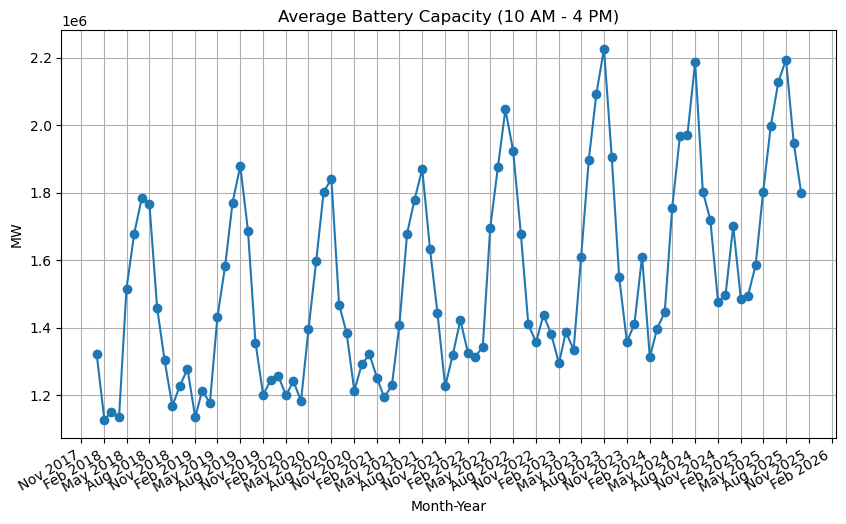

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd



# 1. Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_results['Month_Dt'], df_results['Average_10am_4pm'], marker='o', linestyle='-')

# 2. Format the chart
plt.title('Average Battery Capacity (10 AM - 4 PM)')
plt.xlabel('Month-Year')
plt.ylabel('MW')
plt.grid(True)

# 3. Format the x-axis dates
# OPTION 1: Set a specific interval (e.g., every 3 months)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

# OPTION 2: Let Matplotlib automatically decide the best spacing (Uncomment to use)
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

plt.show()

We see that we want anywhere from 40-80k MWH of power each hour from 10 - 7 generally. 

Peak current capactiy was at 30,000 MwH.

We have 

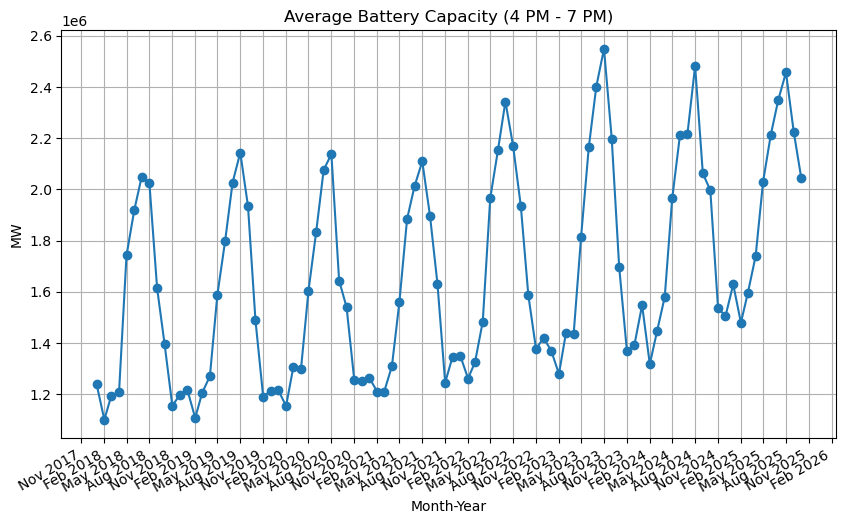

In [44]:


# 1. Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_results['Month_Dt'], df_results['Average_4pm_7pm'], marker='o', linestyle='-')

# 2. Format the chart
plt.title('Average Battery Capacity (4 PM - 7 PM)')
plt.xlabel('Month-Year')
plt.ylabel('MW')
plt.grid(True)

# 3. Format the x-axis dates
# OPTION 1: Set a specific interval (e.g., every 3 months)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

# OPTION 2: Let Matplotlib automatically decide the best spacing (Uncomment to use)
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

plt.show()

In [45]:
for key in hourly_ERCOT.keys():
    print(f"{max(hourly_ERCOT[key])}, Index: {hourly_ERCOT[key].idxmax()}")

73308.153447, Index: 2018-07-19 17:00:00
74665.579486, Index: 2019-08-12 17:00:00
74327.836839, Index: 2020-08-13 17:00:00
73650.57348, Index: 2021-08-24 17:00:00
80037.836007, Index: 2022-07-20 17:00:00
85464.116394, Index: 2023-08-10 18:00:00
85198.85005, Index: 2024-08-20 18:00:00
83679.001697, Index: 2025-08-18 18:00:00


In [46]:
hourly_ERCOT

{2018: HourEnding
 2018-01-01 01:00:00    50567.069682
 2018-01-01 02:00:00    50617.087977
 2018-01-01 03:00:00    50694.300087
 2018-01-01 04:00:00    50999.591693
 2018-01-01 05:00:00    51723.732017
                            ...     
 2018-12-31 19:00:00    40401.898390
 2018-12-31 20:00:00    39802.788822
 2018-12-31 21:00:00    39078.113844
 2018-12-31 22:00:00    38535.683453
 2018-12-31 23:00:00    37851.312753
 Name: ERCOT, Length: 8759, dtype: float64,
 2019: HourEnding
 2019-01-01 01:00:00    37081.443439
 2019-01-01 02:00:00    37258.989933
 2019-01-01 03:00:00    37300.187809
 2019-01-01 04:00:00    37423.543464
 2019-01-01 05:00:00    37895.212293
                            ...     
 2019-12-31 19:00:00    41812.983857
 2019-12-31 20:00:00    41079.759161
 2019-12-31 21:00:00    40145.543121
 2019-12-31 22:00:00    39330.601248
 2019-12-31 23:00:00    38377.355525
 Name: ERCOT, Length: 8759, dtype: float64,
 2020: HourEnding
 2020-01-01 01:00:00    36824.115099
 2020-0

In [47]:
for key in hourly_ERCOT.keys():
    print(f"{max(hourly_ERCOT[key])}, Index: {hourly_ERCOT[key].idxmax()}")

73308.153447, Index: 2018-07-19 17:00:00
74665.579486, Index: 2019-08-12 17:00:00
74327.836839, Index: 2020-08-13 17:00:00
73650.57348, Index: 2021-08-24 17:00:00
80037.836007, Index: 2022-07-20 17:00:00
85464.116394, Index: 2023-08-10 18:00:00
85198.85005, Index: 2024-08-20 18:00:00
83679.001697, Index: 2025-08-18 18:00:00
